<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/SVM_Group_Adolescent_Whole_brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adolescent Group Whole Brain Support Vector Machine Training
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
- load local pickle file containing all masked, normalized Whole Brain subject data in numpy matrix format
- SVM training per group (subject ids of '100XX-XXXXX' for Adolescent (child) and '300XX-XXXXX' for Young Adult)

### Mount Google Drive and clone repository
- open to source directory

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount = True)

Mounted at /content/gdrive


In [2]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source
!ls


Cloning into 'teambrainiac'...
remote: Enumerating objects: 725, done.
remote: Counting objects: 100% (725/725), done.
remote: Compressing objects: 100% (524/524), done.
remote: Total 725 (delta 453), reused 369 (delta 185), pack-reused 0
Receiving objects: 100% (725/725), 68.67 MiB | 10.98 MiB/s, done.
Resolving deltas: 100% (453/453), done.
/content/teambrainiac/source
access_data.py		  process.py
AccuracyMeasures.ipynb	  SingleSubjectSVM.ipynb
analysis.py		  SubjectVisualization_Models_ZNORM.ipynb
cross_validation.py	  SVM_Group_Adolescent_Whole_brain.ipynb
data			  SVM_Group_YA_Whole_brain.ipynb
DL			  TestMask.ipynb
Explore_data.ipynb	  train.py
Group_All_MASK_SVM.ipynb  utils.py
helper			  VisualizationPlayground.ipynb
Images			  Visualize_Data.ipynb
__init__.py		  visualize.py
models


### Load path_config.py 
- we are already in the source directory so we can just load this file without changing directories

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


### Import libraries


In [4]:
# Import libraries
!pip install boto3 nilearn
import pickle
from visualize import plot_alphas, plot_brain_map
from train import run_grp_svm_model
from analysis import create_bmaps, get_threshold_image, metrics
from process import *
from access_data import *

from sklearn.svm import SVC
import numpy as np
from collections import defaultdict
import nibabel as nib
from nilearn import plotting

     |████████████████████████████████| 132 kB 4.1 MB/s 
     |████████████████████████████████| 10.1 MB 16.7 MB/s 
     |████████████████████████████████| 8.7 MB 58.9 MB/s 
     |████████████████████████████████| 79 kB 8.4 MB/s 
     |████████████████████████████████| 138 kB 86.3 MB/s 
     |████████████████████████████████| 127 kB 91.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


### Load Unmasked Data from AWS 
- normalize and transform data
- and obtain Adolescent subjects from first 33 subject IDs

In [44]:
%%time
# Get mat file 
mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'
label_type = 'rt_labels' 
do_norm = True
m_path_ind = 0 #get sub_mask data in mask_data key
l_path_ind = 0 #get data in data from rt_label key

#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)
data_path = "data/"
filename = f"all_data_{mask_type}_psc_2d.pkl"
subject_ids = data_path_dict['subject_ID']

# Split dataset into Adolescent
ad = subject_ids[:33]
print("Number of subjects for Adolescent ", len(ad))

# process data if not in AWS already
obj_name, _, _ = access_aws()
statement = [True if filename in i.key else False for i in obj_name][0] 
if statement == False:
  print("Masking mat data...")
  data = masked_data_n_labels(mask_type, label_type, data_path_dict, do_norm, m_path_ind, l_path_ind)
  print(f"Saving data to local path {data_path}{filename}")
  f = open(f"{data_path}{filename}", "wb")
  pickle.dump(data, f)
  f.close()
else:
  print("Loading in masked data")
  data = access_load_data(filename, False)

Number of subjects for Adolescent  33
Masking mat data...


0it [00:00, ?it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:83: RuntimeWarning: invalid value encountered in true_divide
  signals = (signals - mean_signal) / np.absolute(mean_signal)
/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:87: UserWarning: psc standardization strategy is meaningless for features that have a mean of 0. These time series are set to 0.
  warnings.warn('psc standardization strategy is meaningless '

100%|██████████| 4/4 [00:02<00:00,  1.83it/s]
1it [00:16, 16.53s/it]
100%|██████████| 4/4 [00:01<00:00,  2.48it/s]
2it [00:32, 16.26s/it]
100%|██████████| 4/4 [00:01<00:00,  2.53it/s]
3it [00:48, 15.97s/it]
100%|██████████| 4/4 [00:01<00:00,  2.52it/s]
4it [01:04, 16.00s/it]
100%|██████████| 4/4 [00:01<00:00,  2.47it/s]
5it [01:19, 15.84s/it]
100%|██████████| 4/4 [00:01<00:00,  2.52it/s]
6it [01:35, 15.74s/it]
100%|██████████| 4/4 [00:02<00:00,  1.78it/s]
7it [01:52, 16.05s/it]
100%|██████████| 4/4 [00:01<00

Saving data to local path data/all_data_mask_psc_2d.pkl
CPU times: user 7min 51s, sys: 5min 24s, total: 13min 15s
Wall time: 15min 16s


## SVM Adolescent
- Split subject IDs three ways to make Train, Val, Test sets
- Perform Z-Normalization on the data per run per subject by calling transform_data()
- Run SVM on PSC and Z-normalized Data
- Train/Val/Test set run 2 and 3

In [45]:
# get train, test val data
train_ids = ad[:23]
val_ids = ad[23:28]
test_ids = ad[28:34]

group_sub_ids = (train_ids, val_ids, test_ids)
runs_train = [1,2] # grabs the second run
runs_val = [1,2]
runs_test = [1,2] #2 # grabds the third run
norm = "RUNS" # "RUNS" Normalizes per run; "SUBJECT" Normalized all runs for a given subject; False - no normalization
mask_type = 'whole_brain'
data_type = "Adol_Adol_pscz"


print("Number of Adolescent training examples: ", len(train_ids))
print("Number of Adolescent validation examples: ", len(val_ids))
print("Number of Adolescent testing examples: ", len(test_ids))
print(len(ad))

model_dict = run_grp_svm_model(data, mask_type, group_sub_ids, runs_train, runs_val, runs_test, norm, data_type)

Number of Adolescent training examples:  23
Number of Adolescent validation examples:  5
Number of Adolescent testing examples:  5
33
Normalizing Each based on RUNS...
Final X Train data shape (3864, 237979)
Final y Train data shape  (3864,)
Final X Val data shape (840, 237979)
Final y Val data shape  (840,)
Final X Test data shape (840, 237979)
Final y Test data shape  (840,)
Fitting the model for whole_brain...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


upload complete for models/group/Adol_Adol_pscz_[2, 3]_whole_brain_X_y_model.pkl
Predicting on Validation set...
Validation Accuracy: 0.7011904761904761
Predicting on Test set...
Test Accuracy: 0.7571428571428571
upload complete for metrics/group_svm/Adol_Adol_pscz_model_[2, 3]_whole_brain_validation_classreport.csv
Classification report for whole_brain validation_classreport
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       420
           1       0.69      0.74      0.71       420

    accuracy                           0.70       840
   macro avg       0.70      0.70      0.70       840
weighted avg       0.70      0.70      0.70       840

upload complete for metrics/group_svm/Adol_Adol_pscz_model_[2, 3]_whole_brain_test_classreport.csv
Classification report for whole_brain test_classreport
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       420
           1       0.69      0.

## Visualization Analysis
- Load SVM pretrained model
- Load X train data and labels
- Check Support Vectors
- Create Alphas from dual coefficients/model weights and load into support vector indices
- Take the dot product of alphas and X train data and create a bmap
- Using the bmap we recreate the 4D space using 3d mask indices and load the dot product of alphas and X train information into this matrix
- Use this information to visualize the areas of the brain that were learned by the SVM to be areas close to the decision boundary, areas thought of as either upregulating or downregulating

In [46]:
# Load model
#model_dict = access_load_data('models/group/Adolescent_[2, 3]_whole_brain_X_y_model.pkl', False)
print(model_dict.keys())
clf = model_dict['model'][0]
X = model_dict['X_train'][0]
y = model_dict['y_train'][0]

dict_keys(['model', 'X_train', 'y_train'])


In [47]:
print("number of support vectors:", len(clf.support_))
print("indices of support vectors:", clf.support_)
print("support vector shape: ", clf.support_vectors_.shape)
print("number of support vectors for each class:", clf.n_support_)
print("# Values scaled to fit between -1 and 1:", clf.dual_coef_.shape)
print("length of X-train:", len(X))

number of support vectors: 1978
indices of support vectors: [  14   15   20 ... 3850 3852 3856]
support vector shape:  (1978, 237979)
number of support vectors for each class: [999 979]
# Values scaled to fit between -1 and 1: (1, 1978)
length of X-train: 3864


#### Create Beta map for Visualization
- Create Alphas and Bmaps

In [48]:
# Load in affine matrix - helps map the data coordinates to real world coordinates
affine_image = access_load_data('w3rtprun_01.nii',False)
t1_image = access_load_data('single_subj_T1_resampled.nii',False)

# Load in the mask indices to create bmaps
mask_type = 'mask'
m_path_id = 0
indices_mask = load_mask_indices(data_path_dict, mask_type, m_path_ind)

mask shape: (79, 95, 79)


Shape of beta map:  (1, 237979)


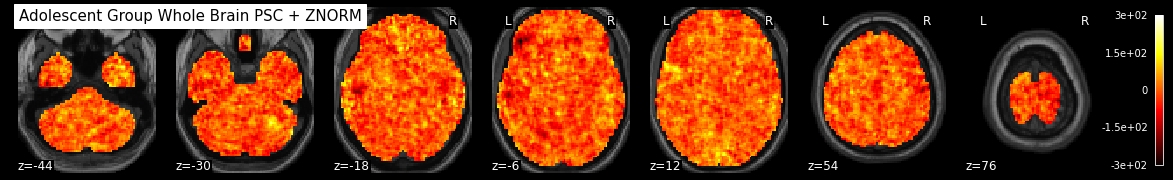

In [66]:
# View Slices of the brain
# get bmaps for visualization
title = "Adolescent Group Whole Brain PSC + ZNORM"
output_file = None# f"/content/gdrive/MyDrive/{data_type}_{mask_type}_statmap_z_1.png" 

bmap3, bmap2_3, alphas1 = create_bmaps(clf, X, indices_mask, affine_image)
plotting.plot_stat_map(bmap3, 
                       bg_img = t1_image,
                       colorbar=True, 
                       cmap='hot', 
                       display_mode='z',
                       title=f"{title}",
                       output_file = output_file)


In [69]:
# Plot Stat maps using thresholds for signal intensity values
score_percentile = '98%' # threshold by top 2% and bottom 2%
image_intensity = 3.0
threshold_percentile_img, threshold_value_img = get_threshold_image(bmap3, score_percentile, image_intensity)
output_file1 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_percent_statmap_y_1.png"
output_file2 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_intensity_statmap_y_1.png"


# Plotting image thresholded by percentile
plotting.plot_stat_map(threshold_percentile_img, 
                       bg_img = t1_image, 
                       display_mode='y', 
                       cut_coords=5,
                    title=f'98th percentile Signal threshold Adolescent PSC + ZNORM Whole Brain', 
                    colorbar=True,
                    output_file=output_file1)

# Showing intensity threshold image
plotting.plot_stat_map(threshold_value_img, 
                       bg_img = t1_image, 
                       display_mode='y', 
                       cut_coords=5,
                       title=f'Image intensity threshold Adolescent PSC + ZNORM Whole Brain', 
                       colorbar=True,
                       output_file=output_file2)

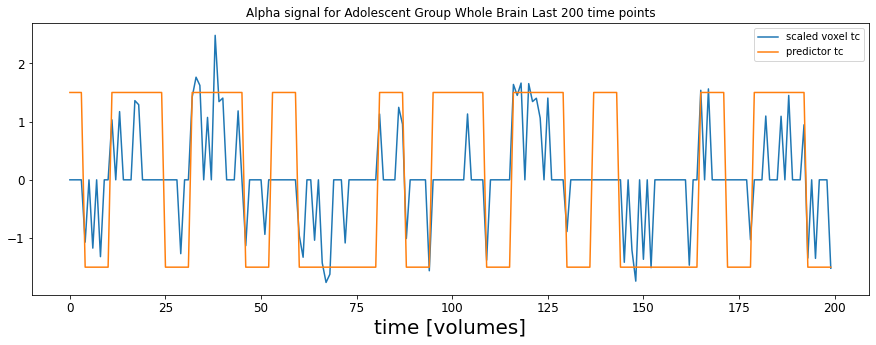

<Figure size 432x288 with 0 Axes>

In [72]:
# Plot the time series with alpha signals and labels
#plt.savefig(f"/content/gdrive/MyDrive/{data_type}_{mask_type}_alphasig_1.png")

title = "Adolescent Group Whole Brain Last"
timepoints = [(200, -1.5, 1.5)]#(100, -1.5, 1.5), 
for time, min, max in timepoints:
  alpha_labels = np.where(y == 0,min,max)
  plot_alphas(alphas1[-time:],alpha_labels[-time:], time, title)

In [73]:
# Plot interactive maps   
html_view = plotting.view_img(bmap3, 
                              bg = t1_image, 
                              threshold='98%', 
                              cmap = 'hot', 
                              cut_coords=[-10, 13, -8],
                              title="Motor contrast")
html_view.save_as_html('/content/gdrive/MyDrive/AD_ADpscnorm_mask_1.html')

In [74]:
# Plotting all slices in brain
title = f'Threshold image with intensity value for for Adolescent PSC_ZNORM Whole Brain'
output_file3 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_pscz_zfullslice.png"
plotting.plot_stat_map(threshold_percentile_img, 
                       bg_img = t1_image, 
                       display_mode='z', 
                       cut_coords=79, 
                       annotate = True,
                       title=title, 
                       colorbar=True,
                       output_file=output_file3)


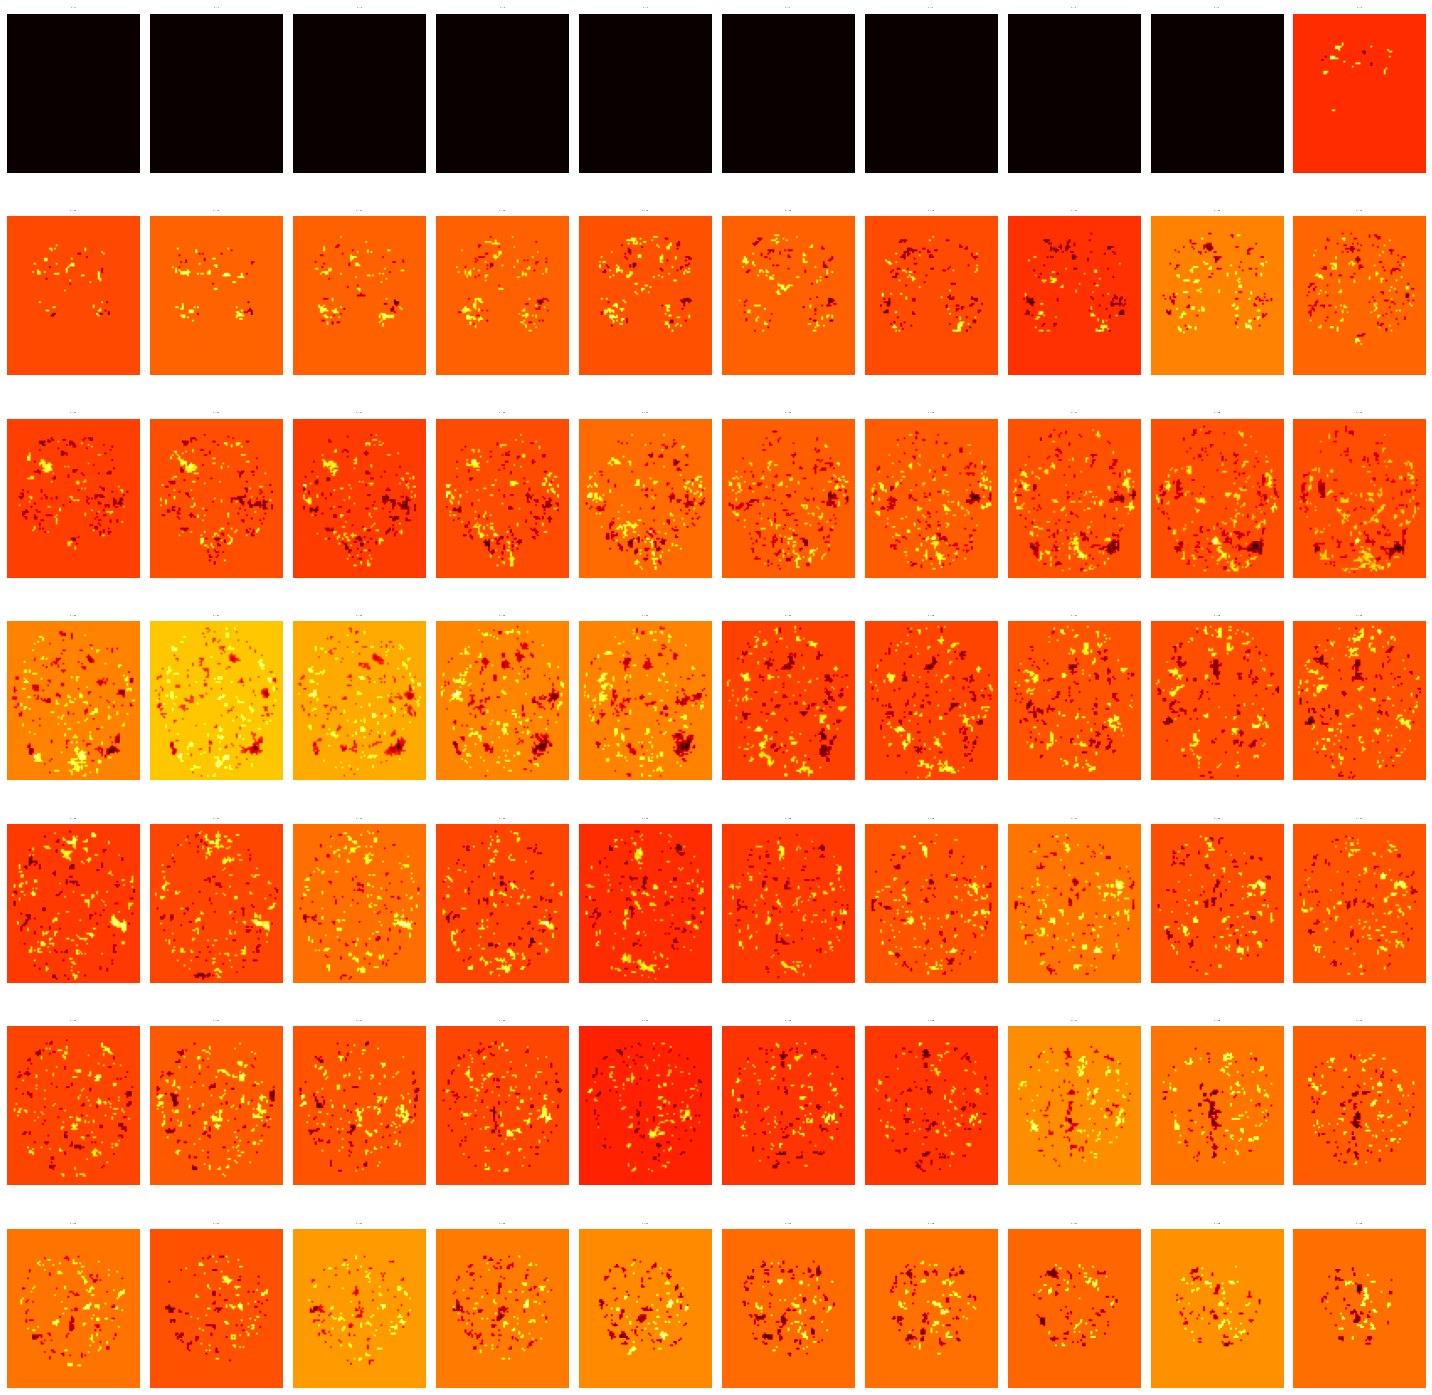

In [60]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=10, nrows=7, figsize=(20, 20))  # 70 slices
# Loop over the first 70 slices
for t, ax in enumerate(axes.flatten()):   
    ax.imshow(bmap2_3[:, :, t].T, cmap='hot')#, origin='lower')  # index with t!
    ax.axis('off')
    ax.set_title('t = %i' % t, fontsize=2)
fig.tight_layout()

## Predict Adolescent on Young Adult Model

In [43]:
# get train, test val data
train_ids = ad[:23]
val_ids = ad[23:28]
test_ids = ad[28:34]

group_sub_ids = (train_ids, val_ids, test_ids)
runs_train = [1,2] # grabs the second run
runs_val = [1,2]
runs_test = [1,2] #2 # grabds the third run
norm = "RUNS" # "RUNS" Normalizes per run; "SUBJECT" Normalized all runs for a given subject; False - no normalization
mask_type = 'whole_brain'
model_type = "YA_YA_pscz"
data_type = "Adolescent_YA"
runs_id = [i+1 for i in runs_train]

print("Number of Adolescent training examples: ", len(train_ids))
print("Number of Adolescent validation examples: ", len(val_ids))
print("Number of Adolescent testing examples: ", len(test_ids))
print(len(ad))

# Get the Data normalized and concatenated
X, y, X_v, y_v, X_t, y_t = transform_data(data, group_sub_ids, runs_train, runs_val, runs_test, norm)

# Load YA model and predict the Adol data
model_dict = access_load_data(f"models/group/{model_type}_{runs_id}_{mask_type}_X_y_model.pkl", False)
print(model_dict.keys())
clf = model_dict['model'][0]

# Analyze results
metrics(clf, X_v, y_v, X_t, y_t, data_type, runs_id, mask_type)

Number of Adolescent training examples:  23
Number of Adolescent validation examples:  5
Number of Adolescent testing examples:  5
33
Normalizing Each based on RUNS...
Final X Train data shape (3864, 237979)
Final y Train data shape  (3864,)
Final X Val data shape (840, 237979)
Final y Val data shape  (840,)
Final X Test data shape (840, 237979)
Final y Test data shape  (840,)
dict_keys(['model', 'X_train', 'y_train'])
Predicting on Validation set...
Validation Accuracy: 0.7214285714285714
Predicting on Test set...
Test Accuracy: 0.7345238095238096
upload complete for metrics/group_svm/Adolescent_YA_model_[2, 3]_whole_brain_validation_classreport.csv
Classification report for whole_brain validation_classreport
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       420
           1       0.71      0.75      0.73       420

    accuracy                           0.72       840
   macro avg       0.72      0.72      0.72       840
weighted

True